In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plots
sns.set(style="whitegrid")


In [3]:
url = "https://raw.githubusercontent.com/jaspreetxkaur/SCT_DS_Task2/main/data/titanic.csv"
df = pd.read_csv(url)

# Quick check
df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# Step 1: Dataset Overview
print("Shape of dataset:", df.shape)

print("\nData Types & Non-Null Counts:")
print(df.info())

print("\nSummary Statistics:")
print(df.describe(include="all"))


Shape of dataset: (891, 12)

Data Types & Non-Null Counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None

Summary Statistics:
        PassengerId    Survived      Pclass                 Name   Sex  \
count    891.000000  891.000000  891.000000                  891   891   
unique     

In [5]:
missing = df.isnull().sum().sort_values(ascending=False)
missing_pct = (df.isnull().mean()*100).sort_values(ascending=False)
missing_summary = pd.concat([missing, missing_pct], axis=1, keys=['Missing','Percent']).loc[lambda x: x['Missing']>0]
missing_summary

,Missing,Percent
Cabin,687,77.104377
Age,177,19.865320
Embarked,2,0.224467


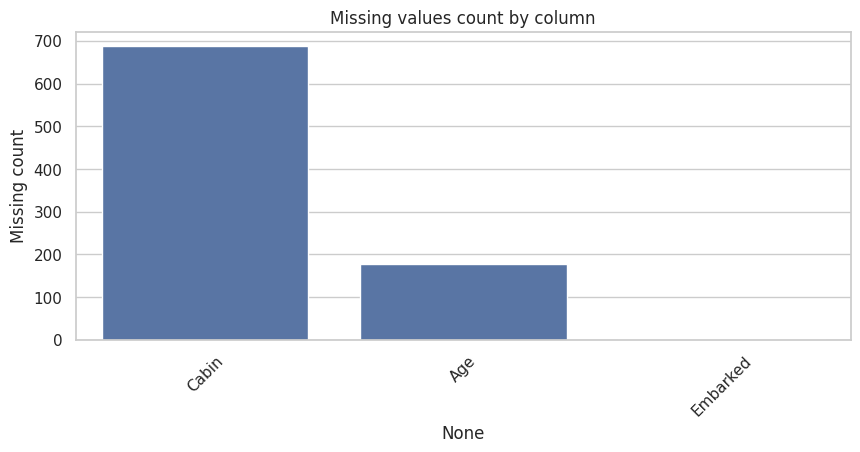

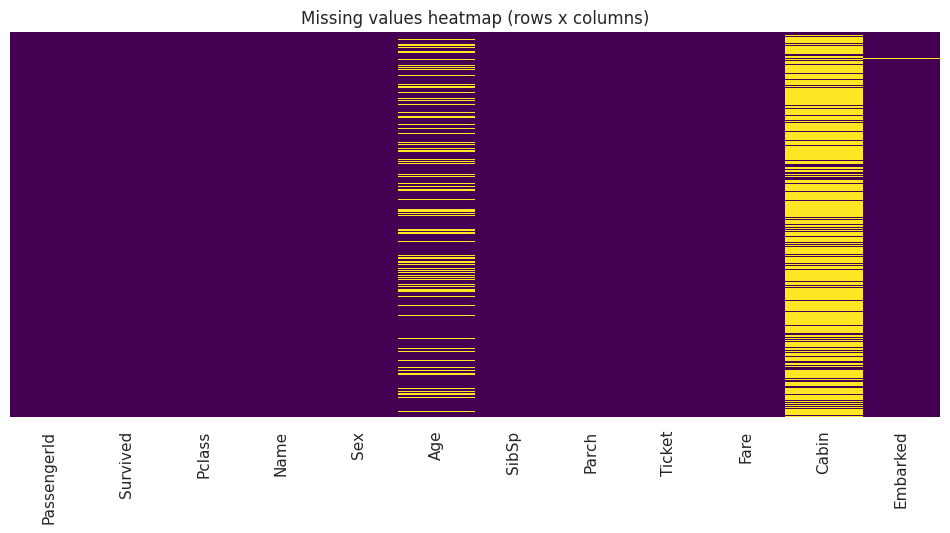

In [6]:

plt.figure(figsize=(10,4))
sns.barplot(x=missing_summary.index, y=missing_summary['Missing'].values)
plt.title('Missing values count by column')
plt.ylabel('Missing count')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12,5))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title('Missing values heatmap (rows x columns)')
plt.show()


In [14]:
# Step 2.3 — Imputation strategy & implementation (Titles + Age prep)

# Reset index to avoid alignment issues
df = df.reset_index(drop=True)

# 1) Extract Title from Name
df['Title'] = df['Name'].str.extract(r',\s*([^\.]+)\.', expand=False).str.strip()

# 2) Normalize common variations
df['Title'] = df['Title'].replace({
    'Mlle': 'Miss',
    'Ms': 'Miss',
    'Mme': 'Mrs'
})

# 3) Group rare titles into 'Rare'
rare_titles = df['Title'].value_counts()[df['Title'].value_counts() < 10].index
df['Title'] = df['Title'].replace(rare_titles, 'Rare')

# 4) Impute Age using median Age within each Title group
df['Age'] = df.groupby('Title')['Age'].transform(lambda x: x.fillna(x.median()))

# 5) Fill missing Embarked with mode
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

# 6) Drop Cabin (too many missing), optional: extract Deck if you want
df = df.drop(columns=['Cabin'])

# Quick check
df.isnull().sum()


,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,0
SibSp,0
Parch,0
Ticket,0
Fare,0


In [13]:
df.columns



Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Title'],
      dtype='object')

In [15]:
# Step 3 — Feature Engineering

# 1) Family Size = SibSp + Parch + 1 (self)
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

# 2) IsAlone (1 if family size == 1 else 0)
df['IsAlone'] = (df['FamilySize'] == 1).astype(int)

# 3) Age Bins (categorical age ranges)
df['AgeBin'] = pd.cut(df['Age'], bins=[0, 12, 18, 35, 60, 80],
                      labels=['Child', 'Teen', 'YoungAdult', 'Adult', 'Senior'])

# 4) Fare Bins (quartiles)
df['FareBin'] = pd.qcut(df['Fare'], 4, labels=['Low', 'Mid', 'High', 'VeryHigh'])

# Quick check
df[['Age', 'AgeBin', 'Fare', 'FareBin', 'FamilySize', 'IsAlone']].head()


,Age,AgeBin,Fare,FareBin,FamilySize,IsAlone
0,22.0,YoungAdult,7.2500,Low,2,0
1,38.0,Adult,71.2833,VeryHigh,2,0
2,26.0,YoungAdult,7.9250,Mid,1,1
3,35.0,YoungAdult,53.1000,VeryHigh,2,0
4,35.0,YoungAdult,8.0500,Mid,1,1


In [16]:
# Step 4 — Encoding Categorical Variables

from sklearn.preprocessing import LabelEncoder

# Columns we want to encode
categorical_cols = ['Sex', 'Embarked', 'Title', 'AgeBin', 'FareBin']

# Apply Label Encoding
le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col].astype(str))

# Quick check
df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title,FamilySize,IsAlone,AgeBin,FareBin
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,2,2,2,0,4,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,0,3,2,0,0,3
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,2,1,1,1,4,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,2,3,2,0,4,3
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,2,2,1,1,4,2


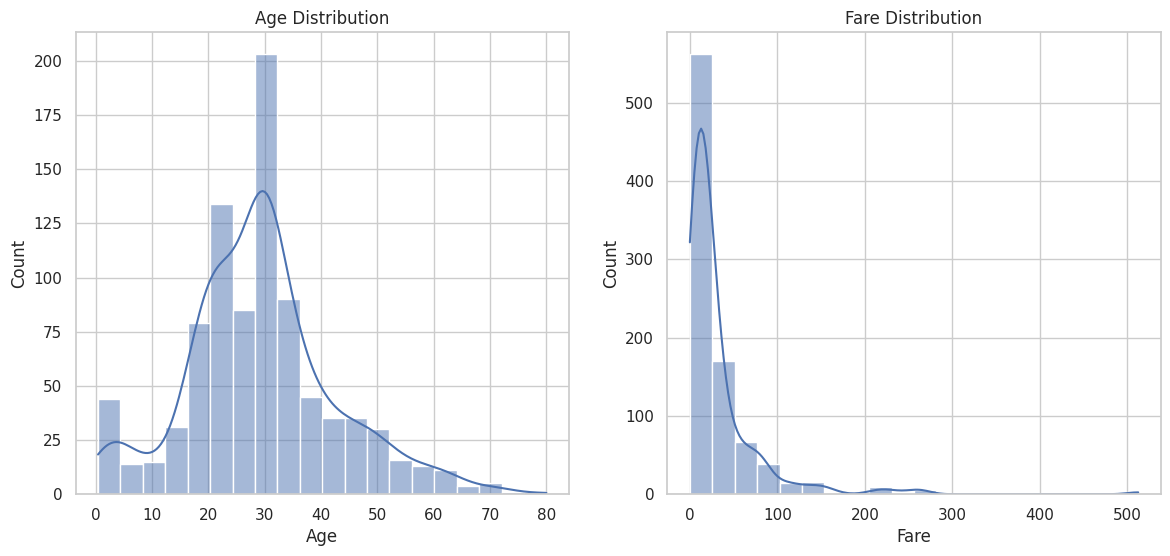

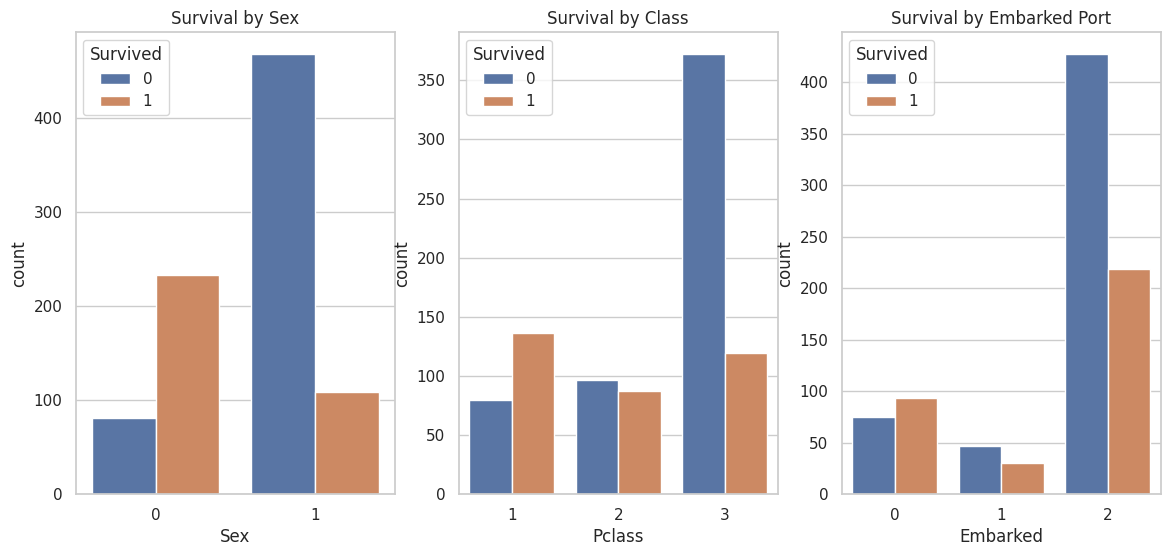

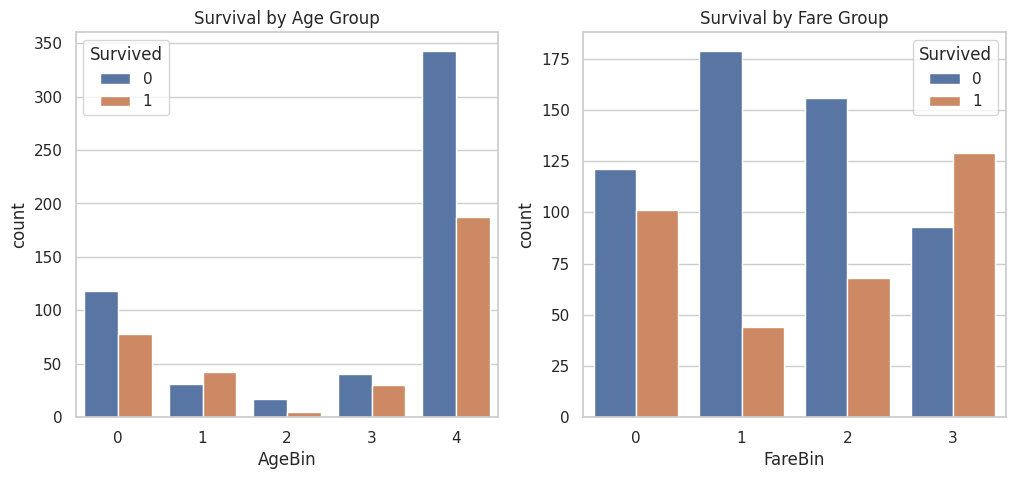

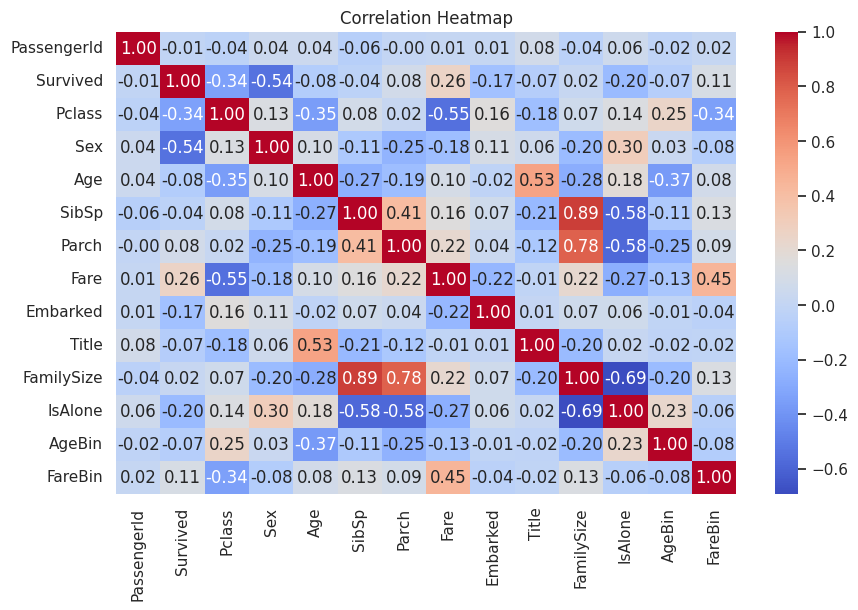

In [18]:
# Step 5 — Exploratory Data Analysis (EDA)

import matplotlib.pyplot as plt
import seaborn as sns

# 5.1 Univariate Distributions
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
sns.histplot(df['Age'], bins=20, kde=True)
plt.title("Age Distribution")

plt.subplot(1,2,2)
sns.histplot(df['Fare'], bins=20, kde=True)
plt.title("Fare Distribution")

plt.show()

# 5.2 Categorical counts vs Survival
plt.figure(figsize=(14,6))

plt.subplot(1,3,1)
sns.countplot(x='Sex', hue='Survived', data=df)
plt.title("Survival by Sex")

plt.subplot(1,3,2)
sns.countplot(x='Pclass', hue='Survived', data=df)
plt.title("Survival by Class")

plt.subplot(1,3,3)
sns.countplot(x='Embarked', hue='Survived', data=df)
plt.title("Survival by Embarked Port")

plt.show()

# 5.3 Survival by AgeBin & FareBin
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.countplot(x='AgeBin', hue='Survived', data=df, order=sorted(df['AgeBin'].unique()))
plt.title("Survival by Age Group")

plt.subplot(1,2,2)
sns.countplot(x='FareBin', hue='Survived', data=df, order=sorted(df['FareBin'].unique()))
plt.title("Survival by Fare Group")

plt.show()

# 5.4 Correlation Heatmap (numeric only)
plt.figure(figsize=(10,6))
numeric_df = df.select_dtypes(include=['int64', 'float64'])
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


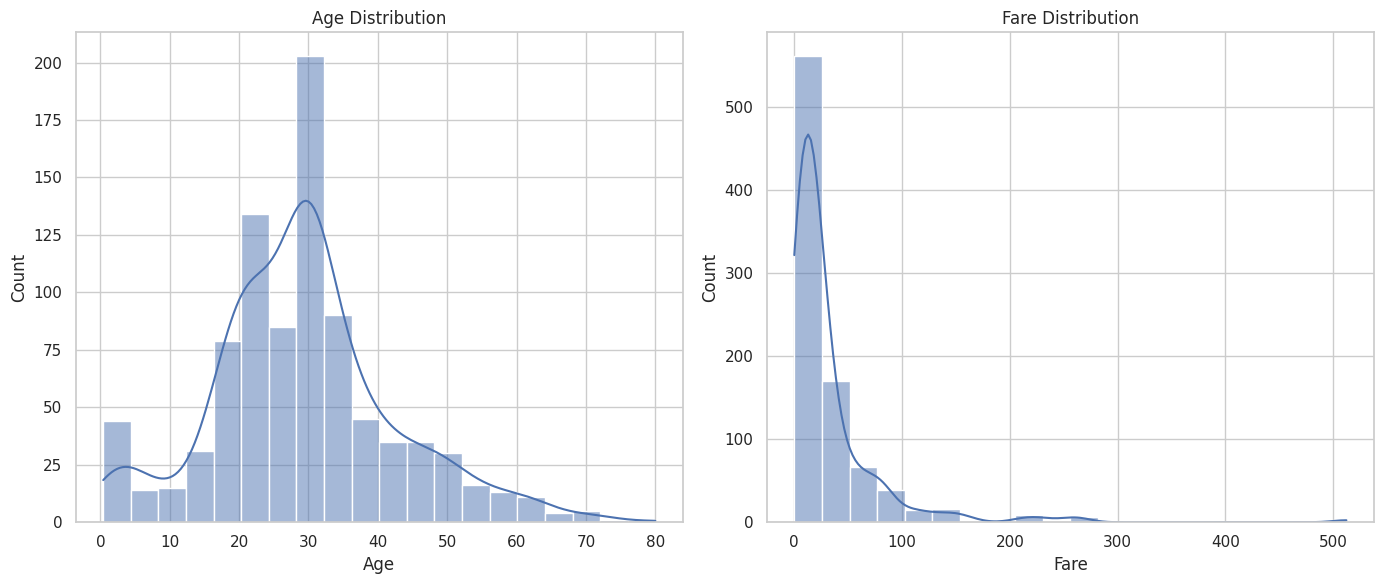

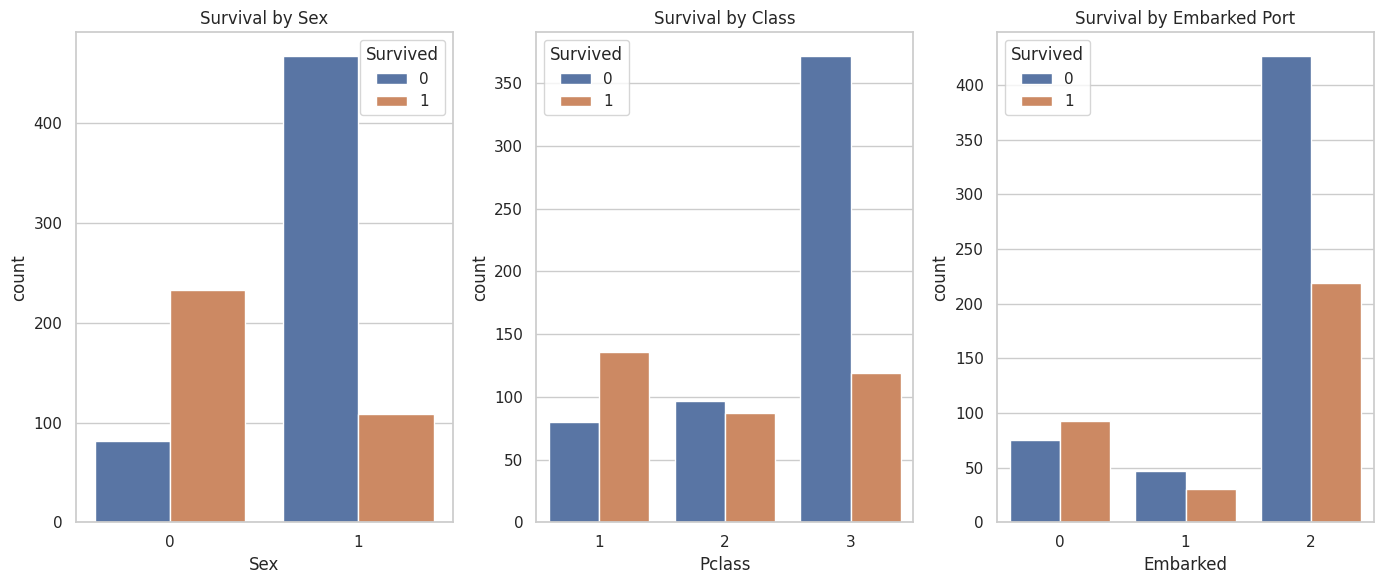

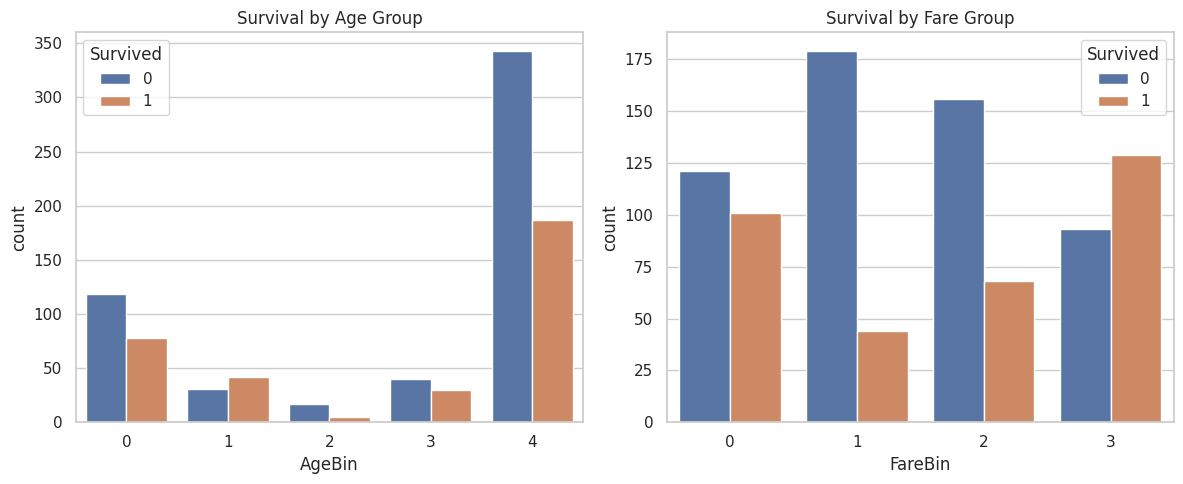

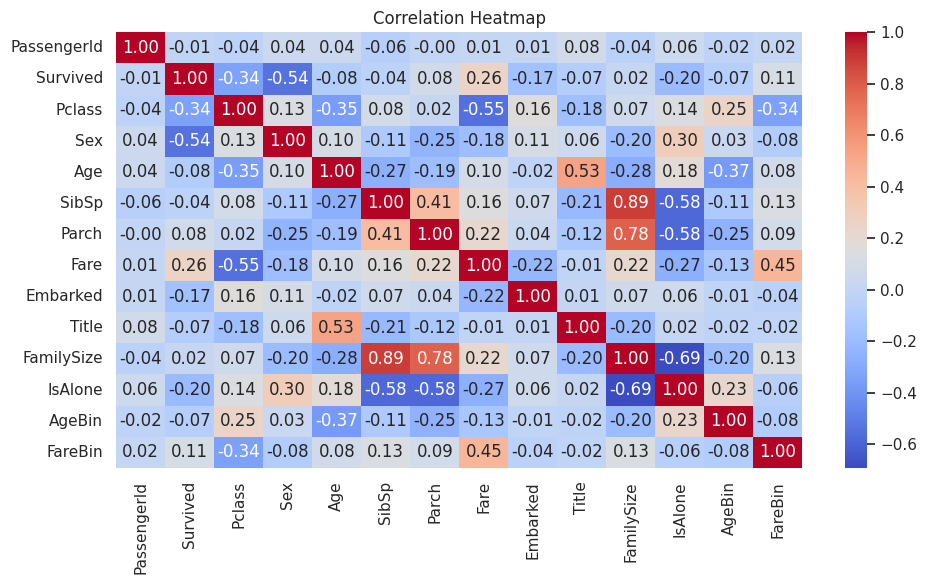

In [19]:
# Step 5 — Exploratory Data Analysis (EDA) with saved visuals

import os
import matplotlib.pyplot as plt
import seaborn as sns

# Create /visuals folder if it doesn't exist
os.makedirs("visuals", exist_ok=True)

# 5.1 Age & Fare Distributions
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
sns.histplot(df['Age'], bins=20, kde=True)
plt.title("Age Distribution")

plt.subplot(1,2,2)
sns.histplot(df['Fare'], bins=20, kde=True)
plt.title("Fare Distribution")

plt.tight_layout()
plt.savefig("visuals/univariate_distributions.png")
plt.show()

# 5.2 Survival by Sex, Class, Embarked
plt.figure(figsize=(14,6))

plt.subplot(1,3,1)
sns.countplot(x='Sex', hue='Survived', data=df)
plt.title("Survival by Sex")

plt.subplot(1,3,2)
sns.countplot(x='Pclass', hue='Survived', data=df)
plt.title("Survival by Class")

plt.subplot(1,3,3)
sns.countplot(x='Embarked', hue='Survived', data=df)
plt.title("Survival by Embarked Port")

plt.tight_layout()
plt.savefig("visuals/survival_categorical.png")
plt.show()

# 5.3 Survival by AgeBin & FareBin
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.countplot(x='AgeBin', hue='Survived', data=df, order=sorted(df['AgeBin'].unique()))
plt.title("Survival by Age Group")

plt.subplot(1,2,2)
sns.countplot(x='FareBin', hue='Survived', data=df, order=sorted(df['FareBin'].unique()))
plt.title("Survival by Fare Group")

plt.tight_layout()
plt.savefig("visuals/survival_bins.png")
plt.show()

# 5.4 Correlation Heatmap
plt.figure(figsize=(10,6))
numeric_df = df.select_dtypes(include=['int64', 'float64'])
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.savefig("visuals/correlation_heatmap.png")
plt.show()


In [20]:
from google.colab import files
import shutil

# Zip the visuals folder
shutil.make_archive("visuals", 'zip', "visuals")

# Download it
files.download("visuals.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>